In [ ]:
import torch
from torchtext.legacy import data

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm',include_lengths = True)
LABEL = data.LabelField(dtype = torch.float)

In [ ]:
from torchtext.legacy import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:02<00:00, 29.4MB/s]


In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 25000
Number of testing examples: 25000


In [ ]:
print(vars(train_data.examples[0]))

{'text': ['Partially', 'from', 'the', 'perceived', 'need', ',', 'one', 'feels', ',', 'to', 'include', 'a', 'conventional', 'love', 'story', 'in', 'the', 'plot', 'to', 'make', 'the', 'film', 'more', 'marketable', 'to', 'a', '1950', "'s", 'movie', '-', 'going', 'public', '.', '<', 'br', '/><br', '/>The', 'film', 'starts', 'with', 'some', 'wickedly', 'funny', 'characterizations', 'of', 'the', 'upper', '-', 'class', 'bureaucrats', 'running', 'the', 'Foreign', 'Office', '---', 'the', 'British', 'are', 'pilloried', 'in', 'the', 'way', 'that', 'only', 'the', 'British', 'can', 'pillory', 'themselves', '.', 'But', 'after', 'that', ',', 'the', 'film', 'loses', 'its', 'way', 'in', 'a', 'conventional', 'farcical', 'plot', '.', 'Terry', '-', 'Thomas', 'watchable', 'as', 'always', ',', 'but', 'the', 'great', 'talent', 'in', 'the', 'cast', '(', 'Peter', 'Sellers', ',', 'et', 'al', ')', 'is', 'largely', 'wasted.<br', '/><br', '/>A', 'diverting', ',', 'but', 'not', 'great', 'film', '.'], 'label': 'pos'

In [ ]:
import random

train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 17500
Number of validation examples: 7500
Number of testing examples: 25000


In [ ]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [02:41, 5.35MB/s]                          
100%|█████████▉| 399555/400000 [00:14<00:00, 27870.38it/s]

In [ ]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


In [ ]:
import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(TEXT.vocab.stoi, tokens)

In [ ]:
print(TEXT.vocab.freqs.most_common(20))

[('the', 204567), (',', 193784), ('.', 166503), ('and', 110555), ('a', 110325), ('of', 101105), ('to', 94367), ('is', 76676), ('in', 61615), ('I', 54671), ('it', 53762), ('that', 49122), ('"', 44537), ("'s", 43712), ('this', 42190), ('-', 37135), ('/><br', 36074), ('was', 35004), ('as', 30326), ('with', 30318)]


In [ ]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']


In [ ]:
print(LABEL.vocab.stoi)

defaultdict(None, {'neg': 0, 'pos': 1})


In [ ]:
BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden)

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [ ]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

model.embedding.weight.data.copy_(pretrained_embeddings)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

torch.Size([25002, 100])
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.9510, -0.3716, -0.9138,  ..., -0.3431, -2.4492, -0.0899],
        [ 0.8701,  1.0967, -0.3292,  ..., -0.4971,  0.6252,  0.2956],
        [ 0.1598, -1.2869,  0.2739,  ...,  0.5660, -0.6778, -0.8444]])


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,810,857 trainable parameters


In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [ ]:
criterion = nn.BCEWithLogitsLoss()

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    fp = ((rounded_preds == 1) & (y==0)).float()
    fn = ((rounded_preds == 0) & (y==1)).float()
    prec = correct.sum()/(correct.sum()+fp.sum())
    rec = correct.sum()/(correct.sum()+fn.sum())
    f1 = 2*((prec*rec)/(prec+rec))
    return acc,prec,rec,f1

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_prec = 0
    epoch_rec = 0
    epoch_f1 = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc,prec,rec,f1 = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_prec += prec.item()
        epoch_rec += rec.item()
        epoch_f1 += f1.item()

        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_prec / len(iterator), epoch_rec / len(iterator),epoch_f1 / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_prec = 0
    epoch_rec = 0
    epoch_f1=0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc,prec,rec,f1 = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_prec += prec.item()
            epoch_rec += rec.item()
            epoch_f1 += f1.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator),epoch_prec / len(iterator),epoch_rec / len(iterator),epoch_f1 / len(iterator)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 5

best_valid_loss = float('inf')
tl = []
vl = []
ta = []
va = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc,train_prec,train_rec,train_f1 = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc,valid_prec,valid_rec,valid_f1 = evaluate(model, valid_iterator, criterion)
    tl.append(train_loss)
    ta.append(train_acc)
    vl.append(valid_loss)
    va.append(valid_acc)
    #epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print(f'\tTrain Prec: {train_prec*100:.2f}% | Val Prec: {valid_prec*100:.2f}%')
    print(f'\t Train. Rec: {train_rec*100:.2f}% |  Val. Rec: {valid_rec*100:.2f}%')
    print(f'\t Train. F1: {train_f1*100:.2f}% |  Val. F1: {valid_f1*100:.2f}%')

Epoch: 01
	Train Loss: 0.213 | Train Acc: 91.88%
	 Val. Loss: 0.270 |  Val. Acc: 89.10%
	Train Prec: 95.75% | Val Prec: 94.28%
	 Train. Rec: 95.82% |  Val. Rec: 94.15%
	 Train. F1: 95.71% |  Val. F1: 94.13%
Epoch: 02
	Train Loss: 0.186 | Train Acc: 93.03%
	 Val. Loss: 0.303 |  Val. Acc: 89.51%
	Train Prec: 96.29% | Val Prec: 94.23%
	 Train. Rec: 96.52% |  Val. Rec: 94.67%
	 Train. F1: 96.33% |  Val. F1: 94.37%
Epoch: 03
	Train Loss: 0.161 | Train Acc: 94.13%
	 Val. Loss: 0.284 |  Val. Acc: 89.21%
	Train Prec: 97.08% | Val Prec: 96.42%
	 Train. Rec: 96.91% |  Val. Rec: 92.29%
	 Train. F1: 96.93% |  Val. F1: 94.21%
Epoch: 04
	Train Loss: 0.129 | Train Acc: 95.54%
	 Val. Loss: 0.360 |  Val. Acc: 89.22%
	Train Prec: 97.65% | Val Prec: 92.24%
	 Train. Rec: 97.80% |  Val. Rec: 96.46%
	 Train. F1: 97.68% |  Val. F1: 94.20%
Epoch: 05
	Train Loss: 0.111 | Train Acc: 96.09%
	 Val. Loss: 0.318 |  Val. Acc: 89.77%
	Train Prec: 98.04% | Val Prec: 95.61%
	 Train. Rec: 97.99% |  Val. Rec: 93.63%
	 Tr

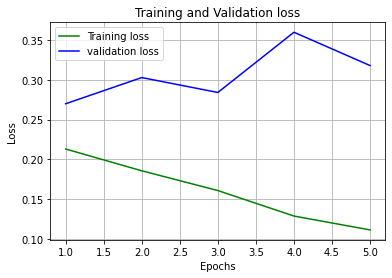

In [ ]:
#  training loss vs validation Accuracy
import matplotlib.pyplot as plt

epochs = range(1,6)
plt.plot(epochs, tl, 'g', label='Training loss')
plt.plot(epochs, vl, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()